In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Input
from keras import backend as K
from keras import layers, models
from keras.layers import LSTM, Dense
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

from spec_generator_sequence import spec_generator
from spec_generator_sequence_multilabel import (spec_generator_multi,
                                                spec_generator_multioutput)
from spec_input_generator import gen, gen_eval
from spectrogram_class import spectrogram


# OrchideaSOL RNN

This is the final notebook working on the Orchidea dataset, preceeding from the music_transcription_2conv.ipynb notebook. In the previous notebook, we have found that:

* Although the loss function of cetegorical cross entropy had been decreasing, our accuracy for predicting the instrument class starts to decrease after the third epoch, for both the training and validating accuracy.
* The training accuracy starts decreasing after the peak of 15%, which is an indicator of either the architecture is unable to capture the feature of the audio files, or the model is optimized wrongly.

> Due to the limited time, we have decided to explore the possibility of RNN/LSTM model, instead of trying to optimize CNN model which appear to have unsatisfactory results.

## Understanding unrolled LSTM, under 10 seconds!

<div>
<img src="unrolled_lstm.webp">
</div>

Image from this [fantastic blog](https://adventuresinmachinelearning.com/keras-lstm-tutorial/).  
10...  
9...  
8...  
7...  
6...  
5...  
4...  
3...  
2...  
1...  
0...  

If you are still here...

## Understanding LSTM, under 1 minute!

LSTM, or more generally RNN, is useful to find the relation between sequential data. Instead of having a fixed length of inputs, and trying to learn the weights for each input in a model, RNN uses previous inputs as a predictor for current prediction!

Each RNN cells can have 2 outputs (or 3 for LSMT, more on that later), and the first output will be feed in to the next LSTM cell, undergoes matrix multiplication, and combined with the input of the next sequential timestep. The cycle goes on. The final output will then be fed into the next layer

If the parameter __return_sequence__ of LSTM is set to true, then each LSTM cell will have a second output, to be fed to the next layer, hence we will have a output with the same length along the sequence. This architecture is called an unrolled LSTM.

In this notebook, we will be using the single output version of LSTM, then feeding the output to layers of Dense layers, to classify the instrument and notes of the audio files.

Summary:
* LSTM works will flexible length of input data
* LSTM uses the previous data as input, transformed using kernel to be learned
* LSTM can produce output of same sequence length.

In [2]:

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-08-07 18:41:28.718001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-07 18:41:28.791105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 18:41:28.828697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 18:41:28.829898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

True

In [5]:
meta_df = pd.read_csv('../data/OrchideaSOL_metadata.csv')

In [7]:
meta_df.shape

(13162, 17)

In [6]:
meta_df = meta_df[~meta_df['Pitch ID (if applicable)'].isna()]

In [8]:
meta_df.isna().sum()

Path                              0
Family (abbr.)                    0
Family (in full)                  0
Instrument (abbr.)                0
Instrument (in full)              0
Technique (abbr.)                 0
Technique (in full)               0
Pitch                             0
Pitch ID (if applicable)          0
Dynamics                          0
Dynamics ID (if applicable)     568
Instance ID                       0
Mute (abbr.)                      0
Mute (in full)                    0
String ID (if applicable)      5666
Needed digital retuning           0
Fold                              0
dtype: int64

In [7]:
meta_df.shape

(13162, 17)

In [8]:
meta_df.head(2)

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,f,3.0,0.0,S,Sordina,NaN,False,2
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,p,1.0,0.0,S,Sordina,NaN,True,0


As of before, the columns we are interested in (instruments and pitch id) doesn't have any null vales, we can just perform the train test split and the rest of the preprocessing is taken by our spectrogram class module.

In [9]:
from random import random


train_df, test_df = train_test_split(meta_df, stratify=meta_df['Instrument (in full)'], 
                                            train_size=0.7, random_state= 42)

In [10]:
multi_generator = spec_generator_multi(train_df, 32)

In [11]:
_, num_target = multi_generator.__getitem__(2)[1].shape
print(num_target)

107


In [12]:
_, num_row, num_col= multi_generator.__getitem__(2)[0].shape
print(num_row)
print(num_col)

500
256


# Rnn two one-hot target

Since we are interested in predicting the instruments and pitchs at the same time, we proposed the following architecture:

* Branching the input into 2 LSTM layers, corresponding to the instruments and notes classificatin.
* Pipe the output in to Dense layer, with dropout and batch normalization
* Pass the output into the classification Dense layer, with the corresponding number of neuron for number of instruments and notes.

In [16]:
BATCH_SIZE = 32
inp = Input((num_row, num_col), batch_size=BATCH_SIZE, )
x = LSTM(200)(inp)
x = layers.Dropout(0.2)(x)
x = layers.Dense(200, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
out1 = layers.Dense(16, activation = 'softmax', name = 'out1')(x)

y = LSTM(200)(inp)
y = layers.Dropout(0.2)(y)
y = layers.Dense(200, activation = 'relu')(y)
y = layers.BatchNormalization()(y)
out2 = layers.Dense(107-16, activation = 'softmax', name = 'out2')(y)

model_2conv_two_out = Model(inp, [out1, out2])

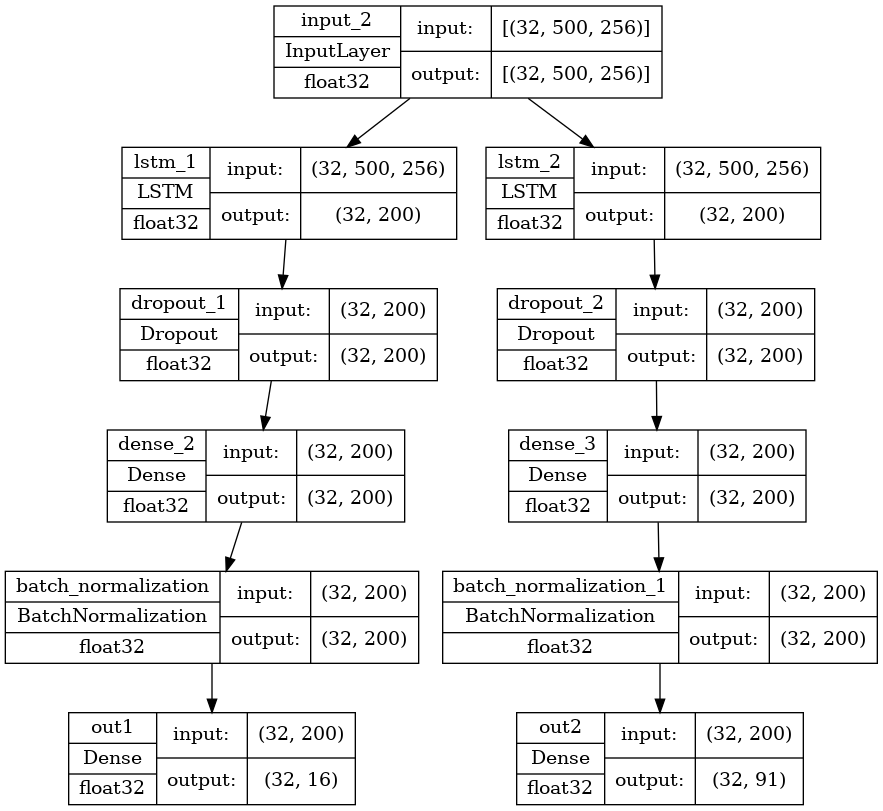

In [17]:
tf.keras.utils.plot_model(model_2conv_two_out, show_shapes=True, show_dtype=True)

In [18]:
model_2conv_two_out.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(32, 500, 256)]     0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (32, 200)            365600      ['input_2[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (32, 200)            365600      ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (32, 200)            0           ['lstm_1[0][0]']                 
                                                                                              

In [19]:
model_2conv_two_out.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss={'out1': tf.keras.losses.CategoricalCrossentropy(),
                    'out2': tf.keras.losses.CategoricalCrossentropy()},
              metrics=['accuracy', tf.keras.metrics.AUC()])

Since for each output layer, we are tryng to predict the one hot encoded instrument and note classes, we will be using categorical cross entropy here.

Also, we will be using the AUC to gauge how well the model is performing.

In [20]:
multioutput_generator = spec_generator_multioutput(train_df, 32)
multioutput_test_generator = spec_generator_multioutput(test_df, 32)

In [21]:
multioutput_generator.__getitem__(32)[0].shape

(32, 500, 256)

In [22]:
# model_2conv_two_out = models.load_model('../models/rnn/first/')

In [23]:
# from datetime import datetime

# ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
#     f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_rnn_multioutput", 
#                                                     monitor='val_accuracy',
#                                                     save_freq = 287*5)
# early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

# history = model_2conv_two_out.fit(multioutput_generator, epochs=100, 
#                         validation_data= multioutput_test_generator, 
#                         callbacks=[ckpt_callback])

Epoch 1/100


2022-07-27 21:47:41.128381: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


287/287 [==============================] - 53s 168ms/step - loss: 7.2355 - out1_loss: 2.7267 - out2_loss: 4.5088 - out1_accuracy: 0.1138 - out1_auc: 0.6068 - out2_accuracy: 0.0142 - out2_auc: 0.5101 - val_loss: 7.1677 - val_out1_loss: 2.6802 - val_out2_loss: 4.4875 - val_out1_accuracy: 0.1479 - val_out1_auc: 0.6766 - val_out2_accuracy: 0.0218 - val_out2_auc: 0.5000
Epoch 2/100
287/287 [==============================] - 53s 184ms/step - loss: 7.1360 - out1_loss: 2.6474 - out2_loss: 4.4886 - out1_accuracy: 0.1433 - out1_auc: 0.6693 - out2_accuracy: 0.0167 - out2_auc: 0.5433 - val_loss: 7.0866 - val_out1_loss: 2.6193 - val_out2_loss: 4.4673 - val_out1_accuracy: 0.1476 - val_out1_auc: 0.6774 - val_out2_accuracy: 0.0252 - val_out2_auc: 0.5751
Epoch 3/100
287/287 [==============================] - 64s 222ms/step - loss: 7.0720 - out1_loss: 2.6014 - out2_loss: 4.4706 - out1_accuracy: 0.1490 - out1_auc: 0.6795 - out2_accuracy: 0.0185 - out2_auc: 0.5672 - val_loss: 7.0404 - val_out1_loss: 2.578

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_05_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_05_rnn_multioutput/assets


287/287 [==============================] - 73s 253ms/step - loss: 7.0016 - out1_loss: 2.5692 - out2_loss: 4.4324 - out1_accuracy: 0.1453 - out1_auc: 0.6803 - out2_accuracy: 0.0206 - out2_auc: 0.6112 - val_loss: 6.9861 - val_out1_loss: 2.5600 - val_out2_loss: 4.4261 - val_out1_accuracy: 0.1479 - val_out1_auc: 0.6860 - val_out2_accuracy: 0.0158 - val_out2_auc: 0.6169
Epoch 6/100
287/287 [==============================] - 53s 184ms/step - loss: 6.9760 - out1_loss: 2.5597 - out2_loss: 4.4163 - out1_accuracy: 0.1504 - out1_auc: 0.6867 - out2_accuracy: 0.0225 - out2_auc: 0.6296 - val_loss: 6.9823 - val_out1_loss: 2.5623 - val_out2_loss: 4.4201 - val_out1_accuracy: 0.1481 - val_out1_auc: 0.6860 - val_out2_accuracy: 0.0188 - val_out2_auc: 0.6229
Epoch 7/100
287/287 [==============================] - 57s 198ms/step - loss: 6.9596 - out1_loss: 2.5593 - out2_loss: 4.4004 - out1_accuracy: 0.1493 - out1_auc: 0.6858 - out2_accuracy: 0.0212 - out2_auc: 0.6420 - val_loss: 6.9600 - val_out1_loss: 2.573

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_10_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_10_rnn_multioutput/assets


287/287 [==============================] - 80s 278ms/step - loss: 6.9064 - out1_loss: 2.5564 - out2_loss: 4.3500 - out1_accuracy: 0.1454 - out1_auc: 0.6875 - out2_accuracy: 0.0257 - out2_auc: 0.6681 - val_loss: 6.8961 - val_out1_loss: 2.5614 - val_out2_loss: 4.3347 - val_out1_accuracy: 0.1479 - val_out1_auc: 0.6852 - val_out2_accuracy: 0.0236 - val_out2_auc: 0.6722
Epoch 11/100
287/287 [==============================] - 52s 182ms/step - loss: 6.8898 - out1_loss: 2.5540 - out2_loss: 4.3358 - out1_accuracy: 0.1519 - out1_auc: 0.6889 - out2_accuracy: 0.0235 - out2_auc: 0.6711 - val_loss: 6.8875 - val_out1_loss: 2.5650 - val_out2_loss: 4.3226 - val_out1_accuracy: 0.1245 - val_out1_auc: 0.6843 - val_out2_accuracy: 0.0236 - val_out2_auc: 0.6788
Epoch 12/100
287/287 [==============================] - 62s 214ms/step - loss: 6.8777 - out1_loss: 2.5543 - out2_loss: 4.3234 - out1_accuracy: 0.1515 - out1_auc: 0.6885 - out2_accuracy: 0.0235 - out2_auc: 0.6752 - val_loss: 6.8789 - val_out1_loss: 2.5

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_15_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_15_rnn_multioutput/assets


287/287 [==============================] - 105s 364ms/step - loss: 6.8416 - out1_loss: 2.5531 - out2_loss: 4.2885 - out1_accuracy: 0.1498 - out1_auc: 0.6890 - out2_accuracy: 0.0254 - out2_auc: 0.6847 - val_loss: 6.8455 - val_out1_loss: 2.5634 - val_out2_loss: 4.2821 - val_out1_accuracy: 0.1507 - val_out1_auc: 0.6833 - val_out2_accuracy: 0.0231 - val_out2_auc: 0.6883
Epoch 16/100
287/287 [==============================] - 77s 267ms/step - loss: 6.8301 - out1_loss: 2.5524 - out2_loss: 4.2778 - out1_accuracy: 0.1481 - out1_auc: 0.6908 - out2_accuracy: 0.0246 - out2_auc: 0.6890 - val_loss: 6.8404 - val_out1_loss: 2.5629 - val_out2_loss: 4.2775 - val_out1_accuracy: 0.1512 - val_out1_auc: 0.6884 - val_out2_accuracy: 0.0249 - val_out2_auc: 0.6874
Epoch 17/100
287/287 [==============================] - 61s 212ms/step - loss: 6.8226 - out1_loss: 2.5519 - out2_loss: 4.2708 - out1_accuracy: 0.1504 - out1_auc: 0.6900 - out2_accuracy: 0.0250 - out2_auc: 0.6918 - val_loss: 6.8364 - val_out1_loss: 2.

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_20_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_20_rnn_multioutput/assets


287/287 [==============================] - 82s 286ms/step - loss: 6.8056 - out1_loss: 2.5520 - out2_loss: 4.2536 - out1_accuracy: 0.1485 - out1_auc: 0.6901 - out2_accuracy: 0.0268 - out2_auc: 0.6972 - val_loss: 6.8144 - val_out1_loss: 2.5645 - val_out2_loss: 4.2499 - val_out1_accuracy: 0.1481 - val_out1_auc: 0.6849 - val_out2_accuracy: 0.0229 - val_out2_auc: 0.6962
Epoch 21/100
287/287 [==============================] - 51s 178ms/step - loss: 6.7995 - out1_loss: 2.5517 - out2_loss: 4.2478 - out1_accuracy: 0.1499 - out1_auc: 0.6898 - out2_accuracy: 0.0257 - out2_auc: 0.6980 - val_loss: 6.8098 - val_out1_loss: 2.5624 - val_out2_loss: 4.2474 - val_out1_accuracy: 0.1245 - val_out1_auc: 0.6819 - val_out2_accuracy: 0.0229 - val_out2_auc: 0.6948
Epoch 22/100
287/287 [==============================] - 60s 210ms/step - loss: 6.7971 - out1_loss: 2.5524 - out2_loss: 4.2447 - out1_accuracy: 0.1462 - out1_auc: 0.6898 - out2_accuracy: 0.0249 - out2_auc: 0.6972 - val_loss: 6.8041 - val_out1_loss: 2.5

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_25_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_25_rnn_multioutput/assets


287/287 [==============================] - 97s 338ms/step - loss: 6.7809 - out1_loss: 2.5463 - out2_loss: 4.2346 - out1_accuracy: 0.1478 - out1_auc: 0.6919 - out2_accuracy: 0.0261 - out2_auc: 0.6987 - val_loss: 6.8006 - val_out1_loss: 2.5598 - val_out2_loss: 4.2408 - val_out1_accuracy: 0.1242 - val_out1_auc: 0.6879 - val_out2_accuracy: 0.0229 - val_out2_auc: 0.6963
Epoch 26/100
287/287 [==============================] - 57s 200ms/step - loss: 6.7698 - out1_loss: 2.5365 - out2_loss: 4.2333 - out1_accuracy: 0.1505 - out1_auc: 0.6950 - out2_accuracy: 0.0229 - out2_auc: 0.6985 - val_loss: 8.7131 - val_out1_loss: 4.4687 - val_out2_loss: 4.2444 - val_out1_accuracy: 0.0371 - val_out1_auc: 0.6212 - val_out2_accuracy: 0.0226 - val_out2_auc: 0.6982
Epoch 27/100
287/287 [==============================] - 61s 214ms/step - loss: 6.7541 - out1_loss: 2.5244 - out2_loss: 4.2297 - out1_accuracy: 0.1644 - out1_auc: 0.7013 - out2_accuracy: 0.0249 - out2_auc: 0.6993 - val_loss: 6.9577 - val_out1_loss: 2.7

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_30_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_30_rnn_multioutput/assets


287/287 [==============================] - 83s 289ms/step - loss: 6.7360 - out1_loss: 2.5117 - out2_loss: 4.2243 - out1_accuracy: 0.1705 - out1_auc: 0.7091 - out2_accuracy: 0.0236 - out2_auc: 0.7001 - val_loss: 9.9162 - val_out1_loss: 5.6891 - val_out2_loss: 4.2270 - val_out1_accuracy: 0.0373 - val_out1_auc: 0.5545 - val_out2_accuracy: 0.0236 - val_out2_auc: 0.6994
Epoch 31/100
287/287 [==============================] - 60s 208ms/step - loss: 6.7247 - out1_loss: 2.5005 - out2_loss: 4.2242 - out1_accuracy: 0.1768 - out1_auc: 0.7142 - out2_accuracy: 0.0257 - out2_auc: 0.6993 - val_loss: 9.4025 - val_out1_loss: 5.1772 - val_out2_loss: 4.2253 - val_out1_accuracy: 0.1494 - val_out1_auc: 0.5105 - val_out2_accuracy: 0.0236 - val_out2_auc: 0.6966
Epoch 32/100
287/287 [==============================] - 64s 221ms/step - loss: 6.7354 - out1_loss: 2.5141 - out2_loss: 4.2213 - out1_accuracy: 0.1753 - out1_auc: 0.7096 - out2_accuracy: 0.0226 - out2_auc: 0.6997 - val_loss: 7.1309 - val_out1_loss: 2.8

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_35_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_35_rnn_multioutput/assets


287/287 [==============================] - 82s 282ms/step - loss: 6.6892 - out1_loss: 2.4700 - out2_loss: 4.2192 - out1_accuracy: 0.1864 - out1_auc: 0.7274 - out2_accuracy: 0.0231 - out2_auc: 0.7002 - val_loss: 13.7810 - val_out1_loss: 9.5534 - val_out2_loss: 4.2276 - val_out1_accuracy: 0.0373 - val_out1_auc: 0.4940 - val_out2_accuracy: 0.0231 - val_out2_auc: 0.6976
Epoch 36/100
287/287 [==============================] - 66s 231ms/step - loss: 6.6736 - out1_loss: 2.4554 - out2_loss: 4.2181 - out1_accuracy: 0.1901 - out1_auc: 0.7317 - out2_accuracy: 0.0237 - out2_auc: 0.6994 - val_loss: 7.4920 - val_out1_loss: 3.2654 - val_out2_loss: 4.2267 - val_out1_accuracy: 0.0617 - val_out1_auc: 0.5160 - val_out2_accuracy: 0.0203 - val_out2_auc: 0.6982
Epoch 37/100
287/287 [==============================] - 65s 226ms/step - loss: 6.6448 - out1_loss: 2.4282 - out2_loss: 4.2166 - out1_accuracy: 0.1960 - out1_auc: 0.7409 - out2_accuracy: 0.0265 - out2_auc: 0.6993 - val_loss: 6.9364 - val_out1_loss: 2.

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_40_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_40_rnn_multioutput/assets


287/287 [==============================] - 69s 240ms/step - loss: 6.6327 - out1_loss: 2.4185 - out2_loss: 4.2143 - out1_accuracy: 0.2002 - out1_auc: 0.7442 - out2_accuracy: 0.0283 - out2_auc: 0.6997 - val_loss: 7.0274 - val_out1_loss: 2.8029 - val_out2_loss: 4.2245 - val_out1_accuracy: 0.1341 - val_out1_auc: 0.6977 - val_out2_accuracy: 0.0229 - val_out2_auc: 0.6974
Epoch 41/100
287/287 [==============================] - 50s 175ms/step - loss: 6.6100 - out1_loss: 2.3950 - out2_loss: 4.2150 - out1_accuracy: 0.2022 - out1_auc: 0.7519 - out2_accuracy: 0.0248 - out2_auc: 0.6994 - val_loss: 9.0041 - val_out1_loss: 4.7863 - val_out2_loss: 4.2178 - val_out1_accuracy: 0.1296 - val_out1_auc: 0.5840 - val_out2_accuracy: 0.0236 - val_out2_auc: 0.6983
Epoch 42/100
287/287 [==============================] - 51s 177ms/step - loss: 6.6122 - out1_loss: 2.3989 - out2_loss: 4.2133 - out1_accuracy: 0.1999 - out1_auc: 0.7502 - out2_accuracy: 0.0257 - out2_auc: 0.7001 - val_loss: 10.3175 - val_out1_loss: 6.

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_45_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_45_rnn_multioutput/assets


287/287 [==============================] - 70s 243ms/step - loss: 6.7673 - out1_loss: 2.5559 - out2_loss: 4.2114 - out1_accuracy: 0.1533 - out1_auc: 0.6906 - out2_accuracy: 0.0245 - out2_auc: 0.7003 - val_loss: 6.7758 - val_out1_loss: 2.5579 - val_out2_loss: 4.2179 - val_out1_accuracy: 0.1507 - val_out1_auc: 0.6894 - val_out2_accuracy: 0.0239 - val_out2_auc: 0.6987
Epoch 46/100
287/287 [==============================] - 49s 169ms/step - loss: 6.7636 - out1_loss: 2.5524 - out2_loss: 4.2111 - out1_accuracy: 0.1505 - out1_auc: 0.6910 - out2_accuracy: 0.0248 - out2_auc: 0.6999 - val_loss: 6.7975 - val_out1_loss: 2.5822 - val_out2_loss: 4.2153 - val_out1_accuracy: 0.1250 - val_out1_auc: 0.6790 - val_out2_accuracy: 0.0229 - val_out2_auc: 0.6989
Epoch 47/100
287/287 [==============================] - 53s 183ms/step - loss: 6.7585 - out1_loss: 2.5479 - out2_loss: 4.2106 - out1_accuracy: 0.1475 - out1_auc: 0.6928 - out2_accuracy: 0.0249 - out2_auc: 0.6993 - val_loss: 6.7690 - val_out1_loss: 2.5

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_50_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_50_rnn_multioutput/assets


287/287 [==============================] - 73s 255ms/step - loss: 6.5758 - out1_loss: 2.3659 - out2_loss: 4.2099 - out1_accuracy: 0.2171 - out1_auc: 0.7597 - out2_accuracy: 0.0266 - out2_auc: 0.6995 - val_loss: 6.5985 - val_out1_loss: 2.3870 - val_out2_loss: 4.2115 - val_out1_accuracy: 0.2038 - val_out1_auc: 0.7571 - val_out2_accuracy: 0.0257 - val_out2_auc: 0.6993
Epoch 51/100
287/287 [==============================] - 56s 197ms/step - loss: 6.5714 - out1_loss: 2.3611 - out2_loss: 4.2103 - out1_accuracy: 0.2217 - out1_auc: 0.7606 - out2_accuracy: 0.0249 - out2_auc: 0.6988 - val_loss: 7.3106 - val_out1_loss: 3.0936 - val_out2_loss: 4.2170 - val_out1_accuracy: 0.1316 - val_out1_auc: 0.6783 - val_out2_accuracy: 0.0236 - val_out2_auc: 0.6962
Epoch 52/100
287/287 [==============================] - 54s 188ms/step - loss: 6.5598 - out1_loss: 2.3499 - out2_loss: 4.2099 - out1_accuracy: 0.2142 - out1_auc: 0.7651 - out2_accuracy: 0.0247 - out2_auc: 0.7003 - val_loss: 10.1792 - val_out1_loss: 5.

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_55_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_55_rnn_multioutput/assets


287/287 [==============================] - 76s 267ms/step - loss: 6.5614 - out1_loss: 2.3536 - out2_loss: 4.2079 - out1_accuracy: 0.2119 - out1_auc: 0.7639 - out2_accuracy: 0.0243 - out2_auc: 0.7000 - val_loss: 8.4125 - val_out1_loss: 4.1969 - val_out2_loss: 4.2156 - val_out1_accuracy: 0.0661 - val_out1_auc: 0.5121 - val_out2_accuracy: 0.0229 - val_out2_auc: 0.6967
Epoch 56/100
287/287 [==============================] - 51s 176ms/step - loss: 6.5420 - out1_loss: 2.3331 - out2_loss: 4.2089 - out1_accuracy: 0.2204 - out1_auc: 0.7695 - out2_accuracy: 0.0228 - out2_auc: 0.6997 - val_loss: 7.6374 - val_out1_loss: 3.4221 - val_out2_loss: 4.2152 - val_out1_accuracy: 0.0478 - val_out1_auc: 0.5152 - val_out2_accuracy: 0.0218 - val_out2_auc: 0.6963
Epoch 57/100
287/287 [==============================] - 51s 179ms/step - loss: 6.5671 - out1_loss: 2.3586 - out2_loss: 4.2085 - out1_accuracy: 0.2145 - out1_auc: 0.7625 - out2_accuracy: 0.0257 - out2_auc: 0.6993 - val_loss: 12.2739 - val_out1_loss: 8.

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_60_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_60_rnn_multioutput/assets


287/287 [==============================] - 76s 262ms/step - loss: 6.7847 - out1_loss: 2.5775 - out2_loss: 4.2072 - out1_accuracy: 0.1492 - out1_auc: 0.6870 - out2_accuracy: 0.0212 - out2_auc: 0.6998 - val_loss: 7.3900 - val_out1_loss: 3.1762 - val_out2_loss: 4.2138 - val_out1_accuracy: 0.1242 - val_out1_auc: 0.6532 - val_out2_accuracy: 0.0216 - val_out2_auc: 0.6984
Epoch 61/100
287/287 [==============================] - 50s 173ms/step - loss: 6.7624 - out1_loss: 2.5567 - out2_loss: 4.2057 - out1_accuracy: 0.1493 - out1_auc: 0.6914 - out2_accuracy: 0.0253 - out2_auc: 0.7005 - val_loss: 6.8204 - val_out1_loss: 2.6074 - val_out2_loss: 4.2129 - val_out1_accuracy: 0.1247 - val_out1_auc: 0.6765 - val_out2_accuracy: 0.0165 - val_out2_auc: 0.7008
Epoch 62/100
287/287 [==============================] - 53s 185ms/step - loss: 6.6807 - out1_loss: 2.4734 - out2_loss: 4.2072 - out1_accuracy: 0.1743 - out1_auc: 0.7231 - out2_accuracy: 0.0245 - out2_auc: 0.6994 - val_loss: 7.9439 - val_out1_loss: 3.7

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_65_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_65_rnn_multioutput/assets


287/287 [==============================] - 70s 243ms/step - loss: 6.5754 - out1_loss: 2.3688 - out2_loss: 4.2066 - out1_accuracy: 0.2133 - out1_auc: 0.7595 - out2_accuracy: 0.0277 - out2_auc: 0.7000 - val_loss: 7.4926 - val_out1_loss: 3.2793 - val_out2_loss: 4.2133 - val_out1_accuracy: 0.0470 - val_out1_auc: 0.5504 - val_out2_accuracy: 0.0216 - val_out2_auc: 0.6983
Epoch 66/100
287/287 [==============================] - 48s 168ms/step - loss: 6.5190 - out1_loss: 2.3130 - out2_loss: 4.2060 - out1_accuracy: 0.2342 - out1_auc: 0.7751 - out2_accuracy: 0.0230 - out2_auc: 0.6993 - val_loss: 10.0938 - val_out1_loss: 5.8797 - val_out2_loss: 4.2141 - val_out1_accuracy: 0.1026 - val_out1_auc: 0.4965 - val_out2_accuracy: 0.0257 - val_out2_auc: 0.6962
Epoch 67/100
287/287 [==============================] - 57s 199ms/step - loss: 6.5358 - out1_loss: 2.3284 - out2_loss: 4.2074 - out1_accuracy: 0.2263 - out1_auc: 0.7697 - out2_accuracy: 0.0272 - out2_auc: 0.6997 - val_loss: 6.4591 - val_out1_loss: 2.

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_70_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_70_rnn_multioutput/assets


287/287 [==============================] - 75s 258ms/step - loss: 6.5561 - out1_loss: 2.3527 - out2_loss: 4.2035 - out1_accuracy: 0.2140 - out1_auc: 0.7635 - out2_accuracy: 0.0290 - out2_auc: 0.7003 - val_loss: 6.9692 - val_out1_loss: 2.7608 - val_out2_loss: 4.2084 - val_out1_accuracy: 0.1502 - val_out1_auc: 0.6250 - val_out2_accuracy: 0.0229 - val_out2_auc: 0.7010
Epoch 71/100
287/287 [==============================] - 50s 173ms/step - loss: 6.6223 - out1_loss: 2.4175 - out2_loss: 4.2049 - out1_accuracy: 0.1970 - out1_auc: 0.7427 - out2_accuracy: 0.0248 - out2_auc: 0.7002 - val_loss: 6.6941 - val_out1_loss: 2.4820 - val_out2_loss: 4.2121 - val_out1_accuracy: 0.2063 - val_out1_auc: 0.7610 - val_out2_accuracy: 0.0239 - val_out2_auc: 0.6987
Epoch 72/100
287/287 [==============================] - 54s 187ms/step - loss: 6.4981 - out1_loss: 2.2915 - out2_loss: 4.2066 - out1_accuracy: 0.2302 - out1_auc: 0.7807 - out2_accuracy: 0.0254 - out2_auc: 0.6995 - val_loss: 6.9257 - val_out1_loss: 2.7

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_75_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_75_rnn_multioutput/assets


287/287 [==============================] - 70s 243ms/step - loss: 6.5083 - out1_loss: 2.3029 - out2_loss: 4.2053 - out1_accuracy: 0.2339 - out1_auc: 0.7771 - out2_accuracy: 0.0236 - out2_auc: 0.6999 - val_loss: 6.5778 - val_out1_loss: 2.3678 - val_out2_loss: 4.2100 - val_out1_accuracy: 0.2421 - val_out1_auc: 0.7698 - val_out2_accuracy: 0.0229 - val_out2_auc: 0.6997
Epoch 76/100
287/287 [==============================] - 50s 172ms/step - loss: 6.5301 - out1_loss: 2.3258 - out2_loss: 4.2043 - out1_accuracy: 0.2269 - out1_auc: 0.7700 - out2_accuracy: 0.0242 - out2_auc: 0.6997 - val_loss: 7.8940 - val_out1_loss: 3.6848 - val_out2_loss: 4.2092 - val_out1_accuracy: 0.1273 - val_out1_auc: 0.6391 - val_out2_accuracy: 0.0216 - val_out2_auc: 0.7004
Epoch 77/100
287/287 [==============================] - 53s 183ms/step - loss: 6.4884 - out1_loss: 2.2844 - out2_loss: 4.2040 - out1_accuracy: 0.2373 - out1_auc: 0.7809 - out2_accuracy: 0.0253 - out2_auc: 0.6999 - val_loss: 7.8893 - val_out1_loss: 3.6

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_80_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_80_rnn_multioutput/assets


287/287 [==============================] - 71s 248ms/step - loss: 6.5288 - out1_loss: 2.3241 - out2_loss: 4.2048 - out1_accuracy: 0.2285 - out1_auc: 0.7706 - out2_accuracy: 0.0253 - out2_auc: 0.6996 - val_loss: 9.1698 - val_out1_loss: 4.9549 - val_out2_loss: 4.2149 - val_out1_accuracy: 0.1413 - val_out1_auc: 0.5979 - val_out2_accuracy: 0.0213 - val_out2_auc: 0.6981
Epoch 81/100
287/287 [==============================] - 50s 173ms/step - loss: 6.4855 - out1_loss: 2.2804 - out2_loss: 4.2051 - out1_accuracy: 0.2354 - out1_auc: 0.7824 - out2_accuracy: 0.0253 - out2_auc: 0.6997 - val_loss: 7.2458 - val_out1_loss: 3.0333 - val_out2_loss: 4.2126 - val_out1_accuracy: 0.1247 - val_out1_auc: 0.6775 - val_out2_accuracy: 0.0218 - val_out2_auc: 0.6997
Epoch 82/100
287/287 [==============================] - 54s 189ms/step - loss: 6.4841 - out1_loss: 2.2798 - out2_loss: 4.2043 - out1_accuracy: 0.2358 - out1_auc: 0.7835 - out2_accuracy: 0.0264 - out2_auc: 0.6997 - val_loss: 6.4914 - val_out1_loss: 2.2

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_85_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_85_rnn_multioutput/assets


287/287 [==============================] - 70s 244ms/step - loss: 6.4911 - out1_loss: 2.2872 - out2_loss: 4.2039 - out1_accuracy: 0.2316 - out1_auc: 0.7818 - out2_accuracy: 0.0245 - out2_auc: 0.7004 - val_loss: 8.2922 - val_out1_loss: 4.0789 - val_out2_loss: 4.2133 - val_out1_accuracy: 0.0262 - val_out1_auc: 0.4113 - val_out2_accuracy: 0.0257 - val_out2_auc: 0.6965
Epoch 86/100
287/287 [==============================] - 52s 182ms/step - loss: 6.5151 - out1_loss: 2.3102 - out2_loss: 4.2049 - out1_accuracy: 0.2229 - out1_auc: 0.7738 - out2_accuracy: 0.0230 - out2_auc: 0.7002 - val_loss: 6.8342 - val_out1_loss: 2.6231 - val_out2_loss: 4.2112 - val_out1_accuracy: 0.1601 - val_out1_auc: 0.7204 - val_out2_accuracy: 0.0229 - val_out2_auc: 0.6966
Epoch 87/100
287/287 [==============================] - 51s 177ms/step - loss: 6.4772 - out1_loss: 2.2736 - out2_loss: 4.2036 - out1_accuracy: 0.2334 - out1_auc: 0.7848 - out2_accuracy: 0.0250 - out2_auc: 0.7001 - val_loss: 6.7078 - val_out1_loss: 2.4

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_90_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_90_rnn_multioutput/assets


287/287 [==============================] - 75s 260ms/step - loss: 6.6254 - out1_loss: 2.4218 - out2_loss: 4.2037 - out1_accuracy: 0.1996 - out1_auc: 0.7422 - out2_accuracy: 0.0268 - out2_auc: 0.7000 - val_loss: 6.4555 - val_out1_loss: 2.2452 - val_out2_loss: 4.2104 - val_out1_accuracy: 0.2564 - val_out1_auc: 0.7974 - val_out2_accuracy: 0.0257 - val_out2_auc: 0.7003
Epoch 91/100
287/287 [==============================] - 48s 167ms/step - loss: 6.6052 - out1_loss: 2.4019 - out2_loss: 4.2033 - out1_accuracy: 0.1972 - out1_auc: 0.7489 - out2_accuracy: 0.0255 - out2_auc: 0.7002 - val_loss: 9.8520 - val_out1_loss: 5.6423 - val_out2_loss: 4.2097 - val_out1_accuracy: 0.1242 - val_out1_auc: 0.5711 - val_out2_accuracy: 0.0226 - val_out2_auc: 0.7003
Epoch 92/100
287/287 [==============================] - 53s 185ms/step - loss: 6.4764 - out1_loss: 2.2726 - out2_loss: 4.2037 - out1_accuracy: 0.2412 - out1_auc: 0.7852 - out2_accuracy: 0.0250 - out2_auc: 0.7000 - val_loss: 9.1351 - val_out1_loss: 4.9

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_95_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_95_rnn_multioutput/assets


287/287 [==============================] - 72s 250ms/step - loss: 6.4512 - out1_loss: 2.2478 - out2_loss: 4.2034 - out1_accuracy: 0.2432 - out1_auc: 0.7915 - out2_accuracy: 0.0258 - out2_auc: 0.7000 - val_loss: 6.4388 - val_out1_loss: 2.2260 - val_out2_loss: 4.2128 - val_out1_accuracy: 0.2660 - val_out1_auc: 0.7991 - val_out2_accuracy: 0.0203 - val_out2_auc: 0.6976
Epoch 96/100
287/287 [==============================] - 52s 178ms/step - loss: 6.4703 - out1_loss: 2.2682 - out2_loss: 4.2020 - out1_accuracy: 0.2458 - out1_auc: 0.7855 - out2_accuracy: 0.0244 - out2_auc: 0.7011 - val_loss: 7.1105 - val_out1_loss: 2.9002 - val_out2_loss: 4.2103 - val_out1_accuracy: 0.1468 - val_out1_auc: 0.6379 - val_out2_accuracy: 0.0239 - val_out2_auc: 0.6994
Epoch 97/100
287/287 [==============================] - 54s 189ms/step - loss: 6.4485 - out1_loss: 2.2458 - out2_loss: 4.2028 - out1_accuracy: 0.2471 - out1_auc: 0.7927 - out2_accuracy: 0.0256 - out2_auc: 0.6996 - val_loss: 6.6148 - val_out1_loss: 2.4

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_100_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220727_214736_100_rnn_multioutput/assets


287/287 [==============================] - 69s 239ms/step - loss: 6.4926 - out1_loss: 2.2889 - out2_loss: 4.2037 - out1_accuracy: 0.2491 - out1_auc: 0.7802 - out2_accuracy: 0.0226 - out2_auc: 0.7003 - val_loss: 6.7373 - val_out1_loss: 2.5246 - val_out2_loss: 4.2127 - val_out1_accuracy: 0.1880 - val_out1_auc: 0.7376 - val_out2_accuracy: 0.0229 - val_out2_auc: 0.6981


In [5]:
import pickle

def save_history(history, path):
    with open(path, 'wb+') as f:
        pickle.dump(history, f)
        
def load_history(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [24]:
# save_history(history, '../models/history/rnn_lstm_sgd.pkl')

INFO:tensorflow:Assets written to: ram://7c4046b3-b1c6-4e78-9063-cdf83c9c241b/assets


INFO:tensorflow:Assets written to: ram://7c4046b3-b1c6-4e78-9063-cdf83c9c241b/assets


In [6]:
history = load_history('../models/history/rnn_lstm.pkl')

2022-08-07 21:01:57.965832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 21:01:57.970044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 21:01:57.970515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 21:01:57.988595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 21:01:57.989097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [17]:
history.history.keys()

dict_keys(['loss', 'out1_loss', 'out2_loss', 'out1_accuracy', 'out1_auc_1', 'out2_accuracy', 'out2_auc_1', 'val_loss', 'val_out1_loss', 'val_out2_loss', 'val_out1_accuracy', 'val_out1_auc_1', 'val_out2_accuracy', 'val_out2_auc_1'])

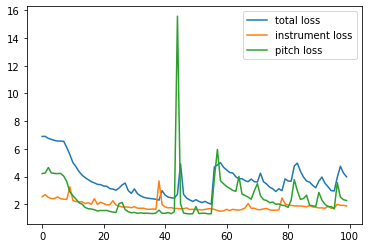

In [18]:
plt.plot(history.history['loss'], label='total loss')
plt.plot(history.history['val_out1_loss'], label = 'instrument loss')
plt.plot(history.history['val_out2_loss'], label = 'pitch loss')
plt.legend()
plt.title('')
plt.show()

Although we have had good results for accuracy, weird behavior starts to happen around 55 epochs, we have a massive drops in notes accuracy, with periodic drops for both accuracies arond 10 epochs. The best results is located in around 70 epochs, with both accuracy peaked around 50%. A more complex model with convolutional layers feeding to LSTM is proposed. 

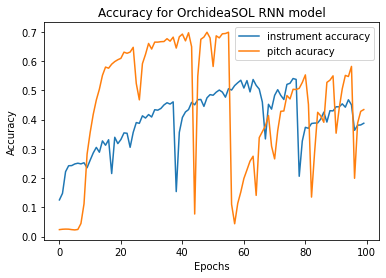

In [8]:
plt.plot(history.history['val_out1_accuracy'], label='instrument accuracy')
plt.plot(history.history['val_out2_accuracy'], label = 'pitch acuracy')
plt.legend()
plt.title('Accuracy for OrchideaSOL RNN model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

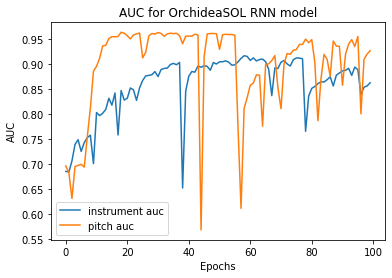

In [9]:
plt.plot(history.history['val_out1_auc_1'], label='instrument auc')
plt.plot(history.history['val_out2_auc_1'], label = 'pitch auc')
plt.legend()
plt.title('AUC for OrchideaSOL RNN model')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.show()

However, just looking at the AUC for both instruments and pitchs, we have a peak AUC for pitch at 0.95, and peak of AUC for instruments at 0.9, which is pretty good.

In [2]:
model_2conv_two_out = tf.keras.models.load_model('../models/baseline_checkpoint/20220725_222035_50_rnn_multioutput')

2022-08-08 07:43:05.125478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 07:43:05.151588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 07:43:05.151962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 07:43:05.153735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [46]:
# model_2conv_two_out.save('../models/rnn_normalized/third')

INFO:tensorflow:Assets written to: ../models/rnn_normalized/third/assets


INFO:tensorflow:Assets written to: ../models/rnn_normalized/third/assets


Seem like we have also meet the limitation of how well a LSTM model can perform in this case. We have also tried changing optimizer to SGD, however the loss function and accuracy only fluctuate, and never decreased.

<div>
<img src="OrchideaSOL_acc.png"/>
</div>

<div>
<img src="OrchideaSOL_loss.png"/>
</div>

The architect below is an exploration of utilizing convlstm model, however, the training time is more than 1 hour for an epoch, and even after 2 epochs the results is not satisfactory. Hence the section below only serves as an remarks.

# Conv + RNN

In [15]:
multioutput_generator_convlstm = spec_generator_multioutput(train_df, 8)
multioutput_test_generator_convlstm = spec_generator_multioutput(test_df, 8)

In [16]:

inp = Input((num_row, num_col, 1), batch_size=8, )
x = layers.ConvLSTM1D(20, 150, kernel_regularizer=tf.keras.regularizers.L1(l1=0.01))(inp)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(30, (30))(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(30, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
out1 = layers.Dense(16, activation = 'softmax', name = 'out1')(x)

y = input(inp) 
y = layers.Dropout(0.2)(y)
y = layers.MaxPooling1D(2)(y)
y = layers.Conv1D(30, (30))(y)
y = layers.MaxPooling1D(2)(y)
y = layers.Flatten()(y)
y = layers.Dense(30, activation = 'relu')(y)
y = layers.BatchNormalization()(y)
out2 = layers.Dense(107-16, activation = 'softmax', name = 'out2')(y)

model_convlstm = Model(inp, [out1, out2])

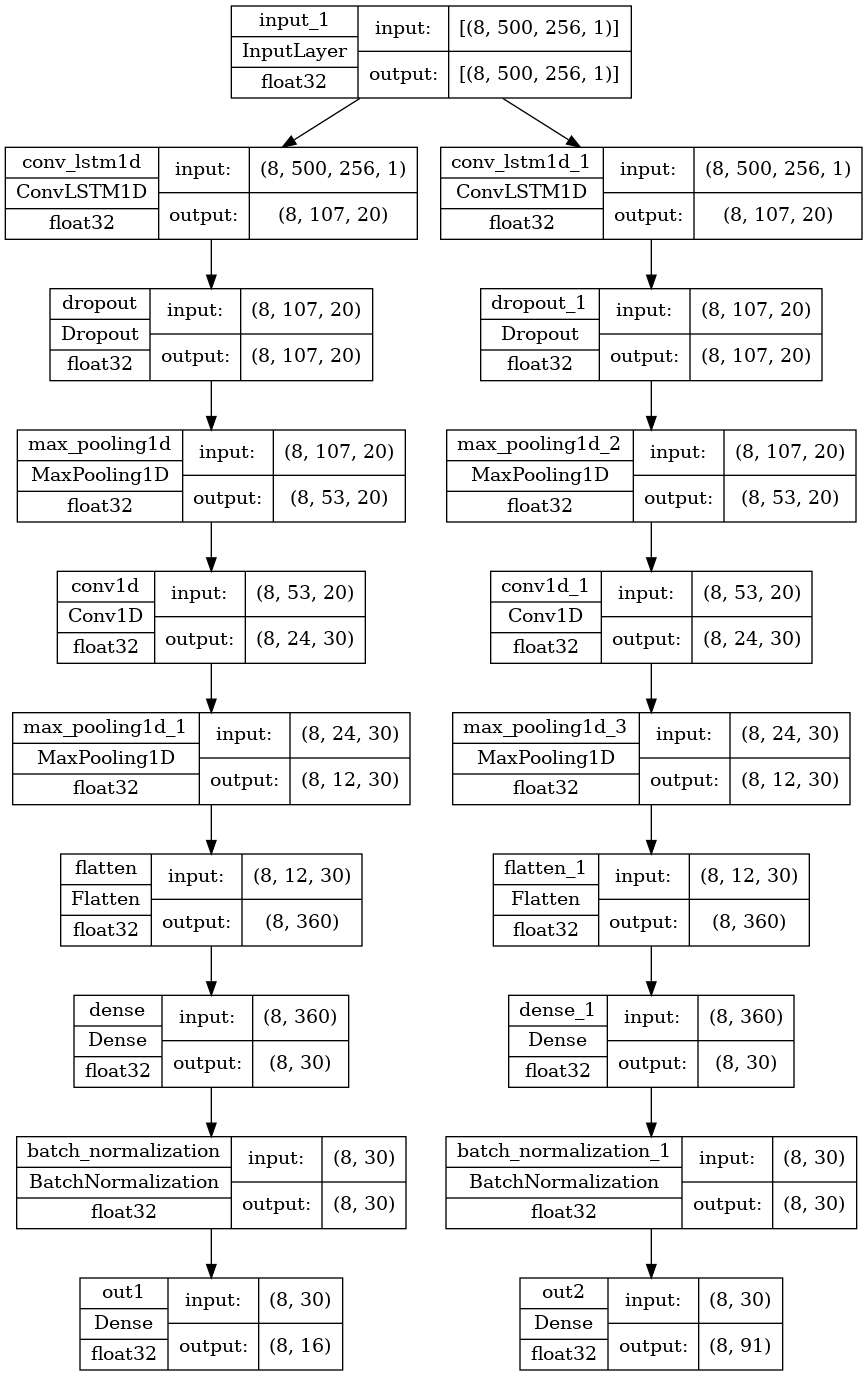

In [17]:
tf.keras.utils.plot_model(model_convlstm , show_shapes=True, show_dtype=True)

In [18]:
model_convlstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(8, 500, 256, 1)]   0           []                               
                                                                                                  
 conv_lstm1d (ConvLSTM1D)       (8, 107, 20)         252080      ['input_1[0][0]']                
                                                                                                  
 conv_lstm1d_1 (ConvLSTM1D)     (8, 107, 20)         252080      ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (8, 107, 20)         0           ['conv_lstm1d[0][0]']            
                                                                                              

In [19]:

model_convlstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              loss={'out1': tf.keras.losses.CategoricalCrossentropy(),
                    'out2': tf.keras.losses.CategoricalCrossentropy()},
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [20]:
!pwd

/bin/bash: /home/shiya/anaconda3/envs/music/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/shiya/Documents/music_transcription/notebooks


In [21]:
new_path = !find ../models/baseline_checkpoint/*rnn_convlstm -maxdepth 0 | sort -nr | head -1
new_path = new_path[1]

In [22]:
print(new_path)

../models/baseline_checkpoint/20220725_132741_02_rnn_convlstm


In [23]:
model_convlstm = tf.keras.models.load_model(new_path)

In [24]:

# from datetime import datetime

# ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
#     f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_rnn_convlstm", 
#                                                     monitor='val_accuracy',
#                                                     save_freq = 287*5)
# early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

# history_convlstm = model_convlstm.fit(multioutput_generator_convlstm, epochs=100, 
#                         validation_data= multioutput_test_generator_convlstm, 
#                         callbacks=[ckpt_callback])

Epoch 1/100


2022-07-26 14:35:05.811908: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-26 14:35:06.434570: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-26 14:35:06.435609: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-26 14:35:06.435633: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-26 14:35:06.436564: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-26 14:35:06.436874: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 261/1151 [=====>........................] - ETA: 41:00 - loss: 6.7734 - out1_loss: 2.5489 - out2_loss: 4.2156 - out1_accuracy: 0.1489 - out1_auc_4: 0.6899 - out2_accuracy: 0.0192 - out2_auc_4: 0.6965

KeyboardInterrupt: 

In [48]:
model_convlstm.save('../models/rnn_convlstm/first')

INFO:tensorflow:Assets written to: ../models/rnn_convlstm/first/assets


INFO:tensorflow:Assets written to: ../models/rnn_convlstm/first/assets
